In this section, we will work through the Income Prediction problem associated with the [Adult Income Census dataset](http://archive.ics.uci.edu/ml/datasets/Adult). The goal is to accurately predict whether or not someone is making more or less than $50,000 a year. Let's take the following steps:

1. Load Libraries
2. Get data, including EDA
3. Clean, prepare and manipulate Data (feature engineering)
4. Modeling (train and test)
5. Algorithm Tuning
6. Finalizing the Model

## 3.1 Load Libraries

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pydotplus
from IPython.display import Image
from sklearn import tree
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
import pickle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE

from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import graphviz



In [0]:
# global varibles
seed = 15
num_folds = 10
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

## 3.2 Get data

In [180]:
# income.csv has not missing values
income = pd.read_csv("income.csv")
income.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## 3.3 Clean, prepare and manipulate **data**

In [181]:
income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
high_income       32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [182]:
# see the transformation in the dataframe
income.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [0]:
# the only step necessary to be done outside of pipeline
# convert the target column to categorical
col = pd.Categorical(income.high_income)
income["high_income"] = col.codes

## 3.4 Modeling (train and test) & tuning

In [0]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self.feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self.feature_names ]

In [0]:
#converts certain features to categorical
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
  #Class constructor method that takes a boolean as its argument
  def __init__(self, new_features=True):
    self.new_features = new_features

  #Return self nothing else to do here    
  def fit( self, X, y = None ):
    return self 
        
  #Transformer method we wrote for this transformer 
  def transform(self, X , y = None ):
    df = X.copy()
    if self.new_features:
      # Treat ? workclass as unknown
      df['workclass']= df['workclass'].replace('?','Unknown') 
      # Two many category level, convert just US and Non-US
      df.loc[df['native_country']!=' United-States','native_country'] = 'non_usa' 

    # convert columns to categorical
    for name in df.columns.to_list():
      col = pd.Categorical(df[name])
      df[name] = col.codes
    
    #returns numpy array
    return df

In [0]:
# split-out train/validation and test dataset
X_train, X_test, y_train, y_test = train_test_split(income.drop(labels="high_income",axis=1),
                                                    income["high_income"],
                                                    test_size=0.30,
                                                    random_state=99,
                                                    shuffle=True,
                                                    stratify=income["high_income"])

In [0]:
# Categrical features to pass down the categorical pipeline 
categorical_features = income.select_dtypes("object").columns.to_list()

# Numerical features to pass down the numerical pipeline 
numerical_features = income.select_dtypes("int64").columns.to_list()

# Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline(steps = [('cat_selector', FeatureSelector(categorical_features)),
                                         ('cat_transformer', CategoricalTransformer())
                                         ])
# Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline(steps = [('num_selector', FeatureSelector(numerical_features)),
                                       ('std_scaler', MinMaxScaler()) 
                                       ])

# Combining numerical and categorical piepline into one full big pipeline horizontally 
# using FeatureUnion
full_pipeline_preprocessing = FeatureUnion(transformer_list = [('categorical_pipeline', categorical_pipeline),
                                                               ('numerical_pipeline', numerical_pipeline)
                                                               ])

In [188]:
income.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [189]:
'''
from sklearn import preprocessing
#Data preparation
# select all categorical variables
df_categorical = income.select_dtypes(include=['object'])

le = preprocessing.LabelEncoder()
df_categorical = df_categorical.apply(le.fit_transform)
le = preprocessing.LabelEncoder()
df_categorical = df_categorical.apply(le.fit_transform)
income = income.drop(df_categorical.columns,axis=1)
income = pd.concat([income,df_categorical],axis=1)
income.head()
'''

"\nfrom sklearn import preprocessing\n#Data preparation\n# select all categorical variables\ndf_categorical = income.select_dtypes(include=['object'])\n\nle = preprocessing.LabelEncoder()\ndf_categorical = df_categorical.apply(le.fit_transform)\nle = preprocessing.LabelEncoder()\ndf_categorical = df_categorical.apply(le.fit_transform)\nincome = income.drop(df_categorical.columns,axis=1)\nincome = pd.concat([income,df_categorical],axis=1)\nincome.head()\n"

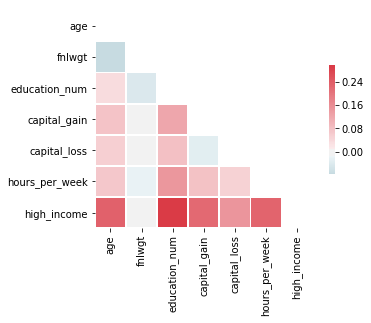

In [190]:
# source: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
mask = np.zeros_like(income.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(income.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [191]:
income.corr()["high_income"].sort_values(ascending=False)

high_income       1.000000
education_num     0.335154
age               0.234037
hours_per_week    0.229689
capital_gain      0.223329
capital_loss      0.150526
fnlwgt           -0.009463
Name: high_income, dtype: float64

In [192]:
# for validate purposes
new_XTrain = full_pipeline_preprocessing.fit_transform(X_train)
new_XTrain_df = pd.DataFrame(new_data,columns = categorical_features + numerical_features)
new_XTrain_df.head()



,workclass,education,marital_status,occupation,relationship,race,sex,native_country,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,4.0,11.0,2.0,8.0,0.0,4.0,1.0,0.0,0.356164,0.121230,0.533333,0.00000,0.0,0.397959
1,4.0,11.0,2.0,6.0,0.0,4.0,1.0,0.0,0.520548,0.063363,0.533333,0.03103,0.0,0.397959
2,7.0,15.0,2.0,1.0,5.0,2.0,0.0,0.0,0.109589,0.114505,0.600000,0.00000,0.0,0.397959
3,4.0,11.0,0.0,8.0,1.0,2.0,0.0,0.0,0.383562,0.070683,0.533333,0.00000,0.0,0.346939
4,4.0,11.0,2.0,7.0,0.0,4.0,1.0,0.0,0.534247,0.014288,0.533333,0.00000,0.0,0.397959


In [0]:
# The full pipeline as a step in another pipeline with an estimator as the final step
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("fs",SelectKBest()),
                         ("classifier",DecisionTreeClassifier())])

# create a dictionary with the hyperparameters
params = {"classifier":[DecisionTreeClassifier()],
                 "classifier__criterion": ["gini","entropy"],
                "classifier__splitter": ["best","random"],
                "classifier__max_depth": range(3,21,3),
                "fs__score_func":[chi2],
                "fs__k":[2,4,6,8]}

# create grid search
kfold = KFold(n_splits=num_folds,random_state=seed)


grid = GridSearchCV(estimator=pipe, 
                    param_grid=params,
                    cv=kfold,
                    scoring=scoring,
                    return_train_score=True,
                    n_jobs=-1,
                    refit="AUC")

# fit grid search
best_model = grid.fit(X_train,y_train)

In [194]:
print("Best: %f using %s" % (best_model.best_score_,best_model.best_params_))

Best: 0.889000 using {'classifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), 'classifier__criterion': 'entropy', 'classifier__max_depth': 9, 'classifier__splitter': 'best', 'fs__k': 8, 'fs__score_func': <function chi2 at 0x7f7dce05cd08>}


## 3.5 Finalize the model

In [195]:
# final model
predict = best_model.predict(X_test)
print(accuracy_score(y_test, predict))
print(confusion_matrix(y_test,predict))
print(classification_report(y_test,predict))

0.8562800696079435
[[7125  292]
 [1112 1240]]
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      7417
           1       0.81      0.53      0.64      2352

    accuracy                           0.86      9769
   macro avg       0.84      0.74      0.77      9769
weighted avg       0.85      0.86      0.84      9769



In [196]:
best_tree = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
best_tree.fit(new_XTrain_df,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

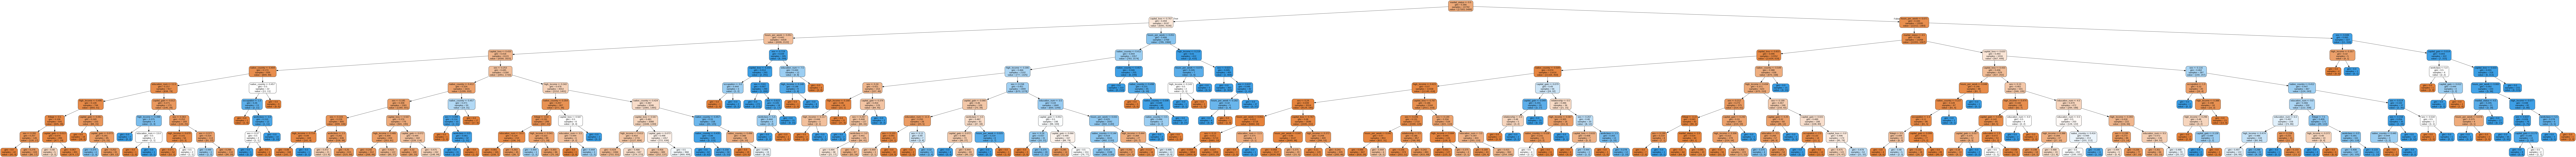

In [197]:
features = list(income.columns[1:])
dot_data = StringIO()  
export_graphviz(best_tree, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())